In [3]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

from PIL import Image
from pose_vector_to_transformation_matrix import \
    pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image

In [140]:
# load camera poses

# each row i of matrix 'poses' contains the transformations that transforms
# points expressed in the world frame to
# points expressed in the camera frame

pose_vectors = np.loadtxt('data/all_pose_vectors_1.txt')

# load camera intrinsics
K = np.loadtxt('data/K_1.txt')  # calibration matrix[3x3]
D = np.loadtxt('data/D_1.txt')  # distortion coefficients[2x1]

# load one image with a given index
img_index = 14
img = cv2.imread('data/images/cam1/cam1_{0:04d}.jpg'.format(img_index))
height, width, _ = img.shape

# project the corners on the image
# compute the 4x4 homogeneous transformation matrix that maps points
# from the world to the camera coordinate frame
T_C_W = pose_vector_to_transformation_matrix(pose_vectors[img_index - 1, :])

In [141]:
# define 3D corner positions
# [Nx3] matrix containing the corners of the checkerboard as 3D points
# (X,Y,Z), expressed in the world coordinate system

square_size = 100  # [mm]
num_corners_x = 7
num_corners_y = 11
num_corners = num_corners_x * num_corners_y

X, Y = np.meshgrid(np.arange(num_corners_x), np.arange(num_corners_y))
p_W_corners = square_size * np.stack([X, Y],
                                        axis=-1).reshape([num_corners, 2])

# add z coordinate, set z=0
p_W_corners = np.concatenate(
    [p_W_corners, np.zeros([num_corners, 1])], axis=-1)

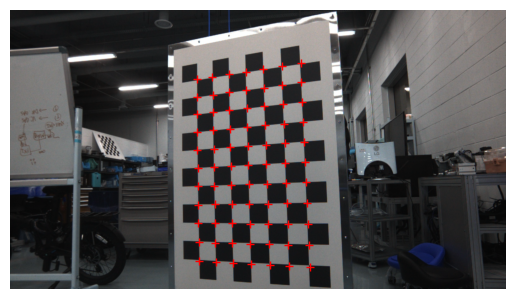

In [142]:
%matplotlib inline

# transform 3d points from world to current camera pose
p_C_corners = np.matmul(T_C_W[None, :, :],
                        np.concatenate([p_W_corners, np.ones([num_corners, 1])], axis=-1)[:, :, None]).squeeze(-1)
p_C_corners = p_C_corners[:, :3]

projected_pts = project_points(p_C_corners, K, D)
plt.imshow(img, cmap='gray')
plt.plot(projected_pts[:, 0], projected_pts[:, 1], 'r+')
plt.axis('off')
plt.show()

Undistortion with bilinear interpolation completed in 39.08138585090637


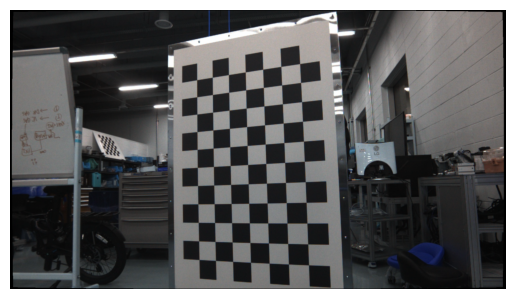

In [143]:
# undistort image with bilinear interpolation
start_t = time.time()
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)
print('Undistortion with bilinear interpolation completed in {}'.format(
    time.time() - start_t))

plt.imshow(img_undistorted, cmap='gray')
plt.axis('off')
plt.show()

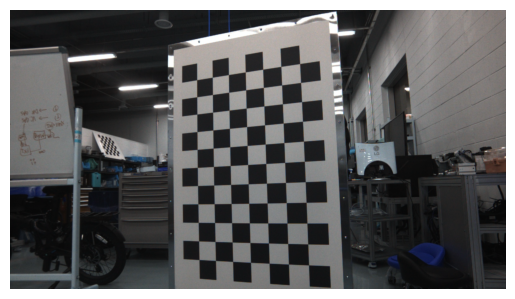

In [144]:
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [167]:
# Re-generate img_undistored
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

# Draw a cube in world coordinate

In [162]:
# calculate the cube points to then draw the image
offset_x = 100 * 3
offset_y = 100
s = 2 * 100

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([
    offset_x + X.flatten()*s,
    offset_y + Y.flatten()*s,
    Z.flatten()*s,
    np.ones([8])], axis=-1)
p_W_cube = p_W_cube.reshape(8, 1, 4)

vertex_id = (
    0, 2, 6, 4, # base layer of the cube
    1, 3, 7, 5, # top layer of the cube
)

lines_id = (
    [0, 1], [2, 3], [4, 5], [6, 7], # vertical lines
    [0, 2], [2, 6], [6, 4], [4, 0], # base lines
    [1, 3], [3, 7], [7, 5], [5, 1], # top lines
)

# set points in world coordinate
num_pts_per_line = 50
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_cube_all = np.zeros((num_pts_per_line * 12, 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_cube_all[indices] = (weights * p_W_cube[line[0]] + (1 - weights) * p_W_cube[line[1]]).reshape(-1, 4)


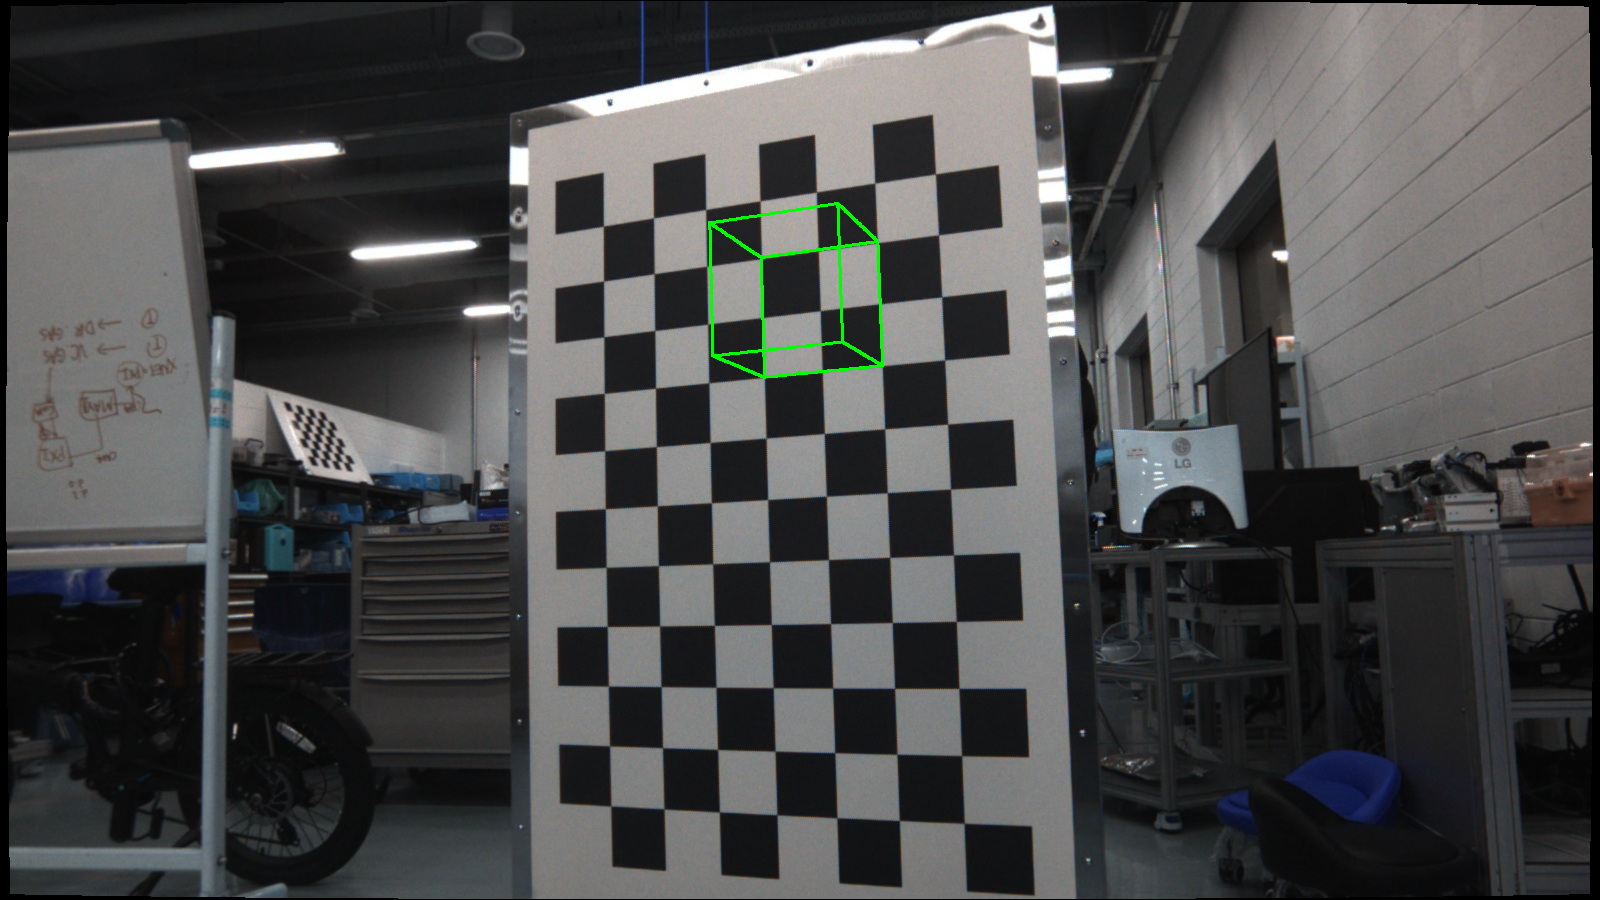

In [163]:
# project on image coordinate
p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube_all[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([4, 1]))
cube_pts_int = cube_pts.astype(int)
cube_pts_int = np.unique(cube_pts_int, axis=0)

# draw points
for x, y in cube_pts_int:
    for iy in range(-1, 2):
        for ix in range(-1, 2):
            img_undistorted[y+iy, x+ix] = (0, 255, 0)

Image.fromarray(img_undistorted)

# Draw XYZ-axis in world coordinate

In [168]:
axis_size = 100

p_W_axis = np.eye(4)[:, :-1]
p_W_axis = axis_size * p_W_axis[:,:3]
p_W_axis = np.c_[p_W_axis, np.ones([4])]
p_W_axis.reshape(4, 1, 4)

# [TODO] 
vertex_id = (
            # vetex of the axis
)

lines_id = (
        # x-axis
        # y-axis
        # z-axis
)

num_pts_per_line = 50
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_axis_all = np.zeros((num_pts_per_line * 3, 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_axis_all[indices] = (weights * p_W_axis[line[0]] + (1 - weights) * p_W_axis[line[1]]).reshape(-1, 4)

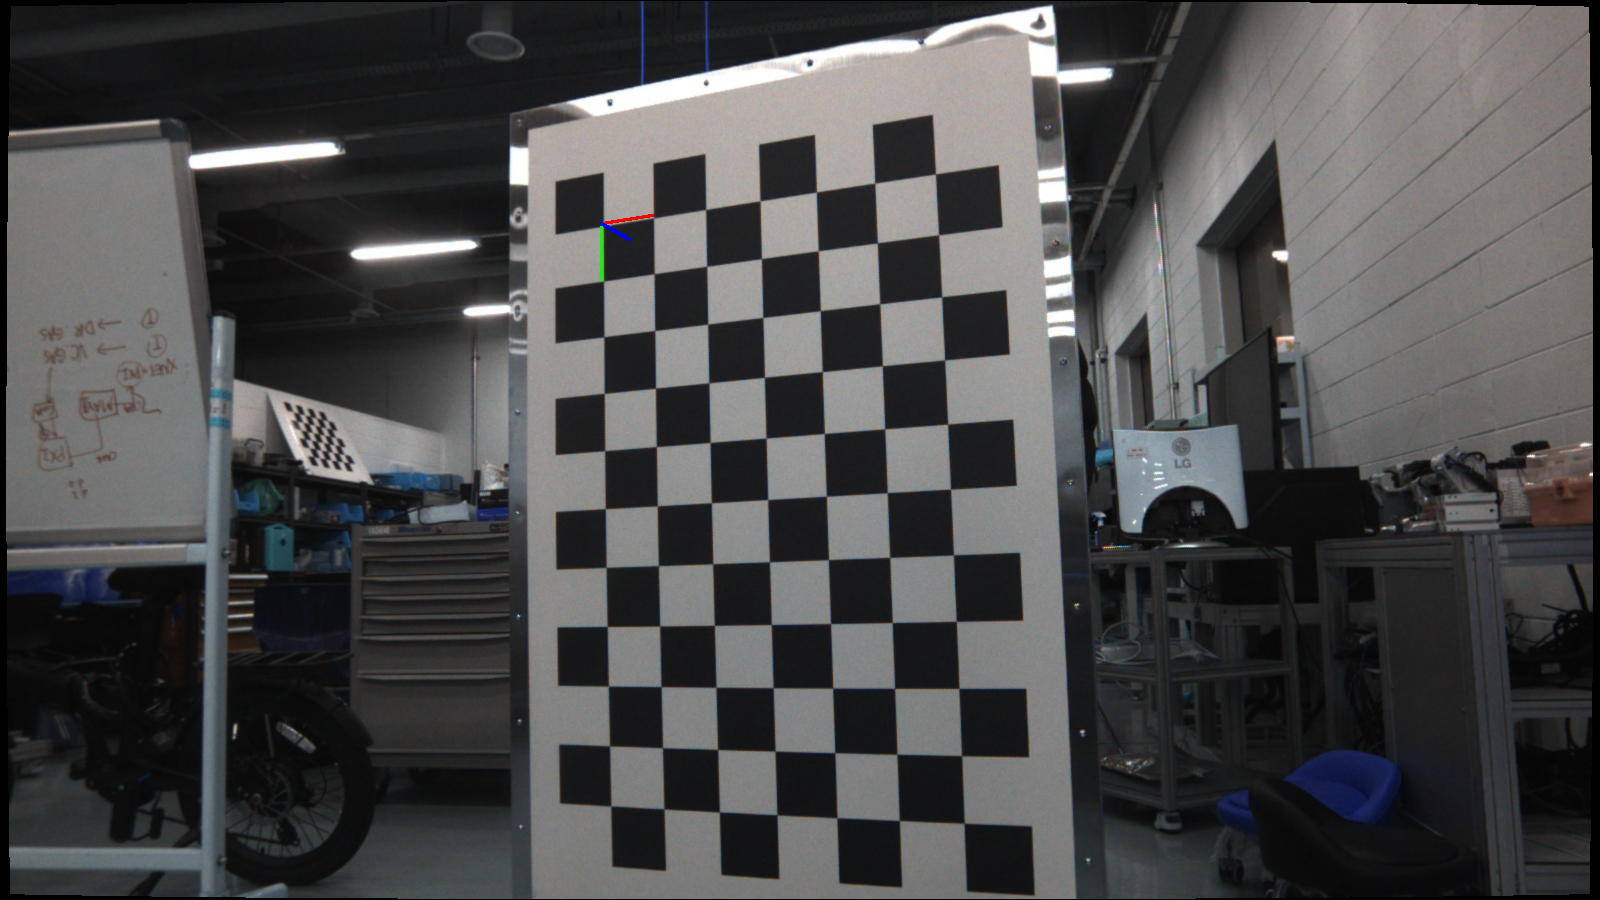

In [170]:
#[TODO] project on image coordinate
p_C_axis = 
p_C_axis = 

axis_pts = 
axis_pts_int = axis_pts.astype(int)

# draw points
for idx, (x, y) in enumerate(axis_pts_int):
    if idx < 50:
        color = (255, 0, 0)
    elif 50 < idx < 100:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    
    for iy in range(-1, 2):
        for ix in range(-1, 2):
            img_undistorted[y+iy, x+ix] = color
            
Image.fromarray(img_undistorted)